<a href="https://colab.research.google.com/github/Dawoodikram482/Music_Genre_Classification/blob/main/Music_Genre_Classification_with_CNNs_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install librosa tensorflow pandas numpy scikit-learn matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import librosa
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from zipfile import ZipFile
import glob

# Define paths in Google Drive (adjust to your folder structure)
BASE_PATH = '/content/drive/MyDrive/CV2-data/'
ANNOTATIONS_PATH = BASE_PATH + 'annotations_final.csv'
ZIP_FILES = [
    BASE_PATH + 'mp3.zip.001',
    BASE_PATH + 'mp3.zip.002',
    BASE_PATH + 'mp3.zip.003'
]
EXTRACTED_DIR = BASE_PATH + 'clips/'

# Create extraction directory if it doesn't exist
os.makedirs(EXTRACTED_DIR, exist_ok=True)

In [ ]:
# Combine split zip files
combined_zip = BASE_PATH + 'mp3_combined.zip'

# Check if combined zip already exists to avoid reprocessing
if not os.path.exists(combined_zip):
    with open(combined_zip, 'wb') as f_out:
        for zip_part in sorted(ZIP_FILES):
            with open(zip_part, 'rb') as f_in:
                f_out.write(f_in.read())
    print(f"Combined zip files into {combined_zip}")
else:
    print(f"Combined zip already exists: {combined_zip}")

# Extract the combined zip
if not os.path.exists(EXTRACTED_DIR + '0'):  # Check if clips are already extracted
    with ZipFile(combined_zip, 'r') as zip_ref:
        zip_ref.extractall(EXTRACTED_DIR)
    print(f"Extracted audio clips to {EXTRACTED_DIR}")
else:
    print(f"Audio clips already extracted in {EXTRACTED_DIR}")

Combined zip files into /content/drive/MyDrive/CV2-data/mp3_combined.zip
Extracted audio clips to /content/drive/MyDrive/CV2-data/clips/


In [ ]:
# Selected genres
selected_genres = ['rock', 'pop', 'jazz', 'classical', 'electronic', 'metal', 'violins', 'folk', 'quick', 'acoustic']

# Load annotations (should already be done, but re-run for consistency)
annotations = pd.read_csv(ANNOTATIONS_PATH, sep='\t')
annotations.head()

,clip_id,no voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...


In [ ]:
# Filter tracks with at least one selected genre
# The annotations file has genres as columns with 1/0 indicating presence
genre_columns = [col for col in annotations.columns if col in selected_genres]
filtered_annotations = annotations[annotations[genre_columns].sum(axis=1) > 0]

# Extract clip_id and genres
clip_ids = filtered_annotations['clip_id']
labels = filtered_annotations[genre_columns]

print(f"Number of selected tracks: {len(filtered_annotations)}")

Number of selected tracks: 10197


In [ ]:
import numpy as np
import librosa
import os
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Parameters
n_mfcc = 40
max_len = 130  # number of frames (roughly 6 seconds at hop_length=512)

# Initialize
X = []
Y = []
skipped_files = []

# Extract MFCCs
for idx, row in tqdm(filtered_annotations.iterrows(), total=len(filtered_annotations)):
    file_path = os.path.join(EXTRACTED_DIR, row['mp3_path'])
    try:
        y, sr = librosa.load(file_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=512)
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        X.append(mfcc)
        Y.append([genre for genre in genre_columns if row[genre] == 1])
    except Exception as e:
        print(f"Error with file {file_path}: {e}")
        skipped_files.append(file_path)

# Convert to numpy arrays
X = np.array(X)
X = X[..., np.newaxis]  # Shape: (n_samples, 40, 130, 1)
mlb = MultiLabelBinarizer(classes=genre_columns)
Y = mlb.fit_transform(Y)

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"Skipped {len(skipped_files)} files")

 95%|█████████▌| 9723/10197 [1:16:16<04:52,  1.62it/s]

Error with file /content/drive/MyDrive/CV2-data/clips/8/jacob_heringman-josquin_des_prez_lute_settings-19-gintzler__pater_noster-204-233.mp3: 


 98%|█████████▊| 10043/10197 [1:18:45<01:15,  2.05it/s]

Error with file /content/drive/MyDrive/CV2-data/clips/9/american_baroque-dances_and_suites_of_rameau_and_couperin-25-le_petit_rien_xiveme_ordre_couperin-88-117.mp3: 


100%|██████████| 10197/10197 [1:19:54<00:00,  2.13it/s]


X shape: (10195, 40, 130, 1)
Y shape: (10195, 10)
Skipped 2 files


In [ ]:
import joblib

np.save("/content/X_mfcc.npy", X)
np.save("/content/Y_binary.npy", Y)

np.save("/content/drive/MyDrive/X_mfcc.npy", X)
np.save("/content/drive/MyDrive/Y_binary.npy", Y)
joblib.dump(mlb, "/content/drive/MyDrive/label_binarizer.pkl")

joblib.dump(mlb, "/content/label_binarizer.pkl")

['/content/label_binarizer.pkl']

Train shapes: X=(7136, 40, 130, 1), Y=(7136, 10)
Validation shapes: X=(1529, 40, 130, 1), Y=(1529, 10)
Test shapes: X=(1530, 40, 130, 1), Y=(1530, 10)

Sample labels (first 5 rows):
Sample 1: ['classical']
Sample 2: ['classical', 'violins']
Sample 3: ['classical']
Sample 4: ['classical', 'violins']
Sample 5: ['electronic', 'rock']


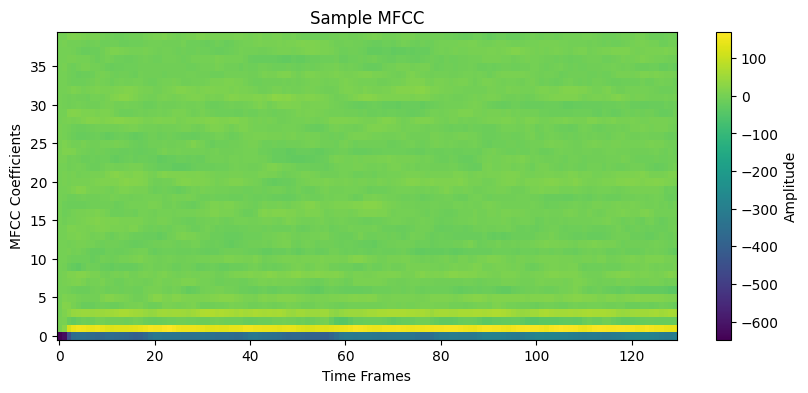

In [ ]:
# Split dataset
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Train shapes: X={X_train.shape}, Y={Y_train.shape}")
print(f"Validation shapes: X={X_val.shape}, Y={Y_val.shape}")
print(f"Test shapes: X={X_test.shape}, Y={Y_test.shape}")

# Print five label rows
print("\nSample labels (first 5 rows):")
for i in range(5):
    genres = [genre_columns[j] for j in range(len(Y[i])) if Y[i][j] == 1]
    print(f"Sample {i+1}: {genres}")

# Plot sample MFCC
plt.figure(figsize=(10, 4))
plt.imshow(X[0, :, :, 0], aspect='auto', origin='lower', cmap='viridis')
plt.title('Sample MFCC')
plt.xlabel('Time Frames')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Amplitude')
plt.show()

# **Custom CNN Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_custom_cnn(input_shape, num_labels):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_labels, activation='sigmoid')  # multi-label output
    ])
    return model


# **VGG Model**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.layers import Resizing

# Model 2: VGG16 with feature extraction
def build_vgg16_model(input_shape, num_labels):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze weights
    model = Sequential([
        Resizing(224, 224, input_shape=input_shape),  # Resize MFCC to VGG input
        tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)),  # Repeat channel to RGB
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_labels, activation='sigmoid')
    ])
    return model

In [ ]:
# Build models
input_shape_cnn = (40, 130, 1)
num_labels = len(genre_columns)

model_cnn = build_custom_cnn(input_shape_cnn, num_labels)

# Model summaries
print("Custom CNN Summary:")
model_cnn.summary()


Custom CNN Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 38, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 128, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 17, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 15872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,031,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,052,234 (7.83 MB)

 Trainable params: 2,052,042 (7.83 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score
import numpy as np

# Compile models
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
                  metrics=['accuracy'])  # Accuracy for monitoring

In [ ]:
import numpy as np
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import Callback

class MultiLabelMetricsCallback(Callback):
    def __init__(self, validation_data, threshold=0.5):
        super().__init__()
        self.X_val, self.Y_val = validation_data
        self.threshold = threshold

        self.hamming_losses = []
        self.precisions = []
        self.recalls = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        Y_pred = self.model.predict(self.X_val, verbose=0)
        Y_pred_bin = (Y_pred > self.threshold).astype(int)

        ham_loss = hamming_loss(self.Y_val, Y_pred_bin)
        precision = precision_score(self.Y_val, Y_pred_bin, average='samples', zero_division=0)
        recall = recall_score(self.Y_val, Y_pred_bin, average='samples', zero_division=0)
        f1 = f1_score(self.Y_val, Y_pred_bin, average='samples', zero_division=0)

        self.hamming_losses.append(ham_loss)
        self.precisions.append(precision)
        self.recalls.append(recall)
        self.f1_scores.append(f1)

        print(f"\nEpoch {epoch + 1} Validation Metrics:")
        print(f"  Hamming Loss: {ham_loss:.4f}")
        print(f"  Precision:    {precision:.4f}")
        print(f"  Recall:       {recall:.4f}")
        print(f"  F1 Score:     {f1:.4f}")



In [ ]:
metrics_cnn = MultiLabelMetricsCallback(validation_data=(X_val, Y_val))

history_cnn = model_cnn.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                            epochs=20, batch_size=32, callbacks=[metrics_cnn])

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.4795 - loss: 0.4946
Epoch 1 Validation Metrics:
  Hamming Loss: 0.0664
  Precision:    0.6651
  Recall:       0.6075
  F1 Score:     0.6257
223/223 ━━━━━━━━━━━━━━━━━━━━ 87s 379ms/step - accuracy: 0.4798 - loss: 0.4940 - val_accuracy: 0.7338 - val_loss: 0.1897
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6595 - loss: 0.2447
Epoch 2 Validation Metrics:
  Hamming Loss: 0.0663
  Precision:    0.6275
  Recall:       0.5664
  F1 Score:     0.5864
223/223 ━━━━━━━━━━━━━━━━━━━━ 135s 348ms/step - accuracy: 0.6594 - loss: 0.2447 - val_accuracy: 0.7188 - val_loss: 0.1748
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6913 - loss: 0.2175
Epoch 3 Validation Metrics:
  Hamming Loss: 0.0624
  Precision:    0.6586
  Recall:       0.5981
  F1 Score:     0.6181
223/223 ━━━━━━━━━━━━━━━━━━━━ 86s 366ms/step - accuracy: 0.6913 - loss: 0.2175 - val_accuracy: 0.7312 - val_loss: 0.1811
Epoch 4/20
223/

In [ ]:
metrics_vgg = MultiLabelMetricsCallback(validation_data=(X_val, Y_val))
history_vgg = model_vgg.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                            epochs=3, batch_size=32, callbacks=[metrics_vgg])

Epoch 1/3
204/223 ━━━━━━━━━━━━━━━━━━━━ 3:57 13s/step - accuracy: 0.4089 - loss: 1.1915

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Resizing, Lambda
import tensorflow as tf

def build_efficientnetb0_model(input_shape, num_labels):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  # Feature extraction

    model = Sequential([
        Resizing(224, 224, input_shape=input_shape),  # Resize MFCC to EfficientNet input
        Lambda(lambda x: tf.repeat(x, 3, axis=-1)),   # Convert grayscale to RGB
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_labels, activation='sigmoid')       # Multi-label output
    ])

    return model


In [ ]:
input_shape_efficientnet = (40, 130, 1)
num_labels = len(genre_columns)

model_effnet = build_efficientnetb0_model(input_shape_efficientnet, num_labels)

print("\nEfficientNetB0 Model Summary:")
model_effnet.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

EfficientNetB0 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,079,149 (46.08 MB)

 Trainable params: 8,029,578 (30.63 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_effnet.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
metrics_effnet = MultiLabelMetricsCallback(validation_data=(X_val, Y_val))
history_effnet = model_effnet.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                            epochs=10, batch_size=32, callbacks=[metrics_effnet])

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step

Epoch 1 Validation Metrics:
  Hamming Loss: 0.0712
  Precision:    0.5746
  Recall:       0.5196
  F1 Score:     0.5376
223/223 ━━━━━━━━━━━━━━━━━━━━ 1045s 5s/step - accuracy: 0.3315 - loss: 0.7433 - val_accuracy: 0.6763 - val_loss: 0.1978
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step

Epoch 2 Validation Metrics:
  Hamming Loss: 0.0714
  Precision:    0.5991
  Recall:       0.5372
  F1 Score:     0.5576
223/223 ━━━━━━━━━━━━━━━━━━━━ 963s 4s/step - accuracy: 0.5636 - loss: 0.2932 - val_accuracy: 0.6991 - val_loss: 0.1866
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step

Epoch 3 Validation Metrics:
  Hamming Loss: 0.0700
  Precision:    0.6148
  Recall:       0.5529
  F1 Score:     0.5733
223/223 ━━━━━━━━━━━━━━━━━━━━ 982s 4s/step - accuracy: 0.6051 - loss: 0.2544 - val_accuracy: 0.7103 - val_loss: 0.1907
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step

Epoch 4 Validation Metrics:
  Hamming Loss: 0.0694
  Precision:    0.6233
  R

In [ ]:
metrics_effnet = MultiLabelMetricsCallback(validation_data=(X_val, Y_val))
history_effnet = model_effnet.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                            epochs=10, batch_size=64, callbacks=[metrics_effnet])

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step

Epoch 1 Validation Metrics:
  Hamming Loss: 0.0617
  Precision:    0.6972
  Recall:       0.6327
  F1 Score:     0.6539
112/112 ━━━━━━━━━━━━━━━━━━━━ 1020s 9s/step - accuracy: 0.6399 - loss: 0.2094 - val_accuracy: 0.7305 - val_loss: 0.1747
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step

Epoch 2 Validation Metrics:
  Hamming Loss: 0.0600
  Precision:    0.6848
  Recall:       0.6232
  F1 Score:     0.6434
112/112 ━━━━━━━━━━━━━━━━━━━━ 1050s 9s/step - accuracy: 0.6523 - loss: 0.2051 - val_accuracy: 0.7430 - val_loss: 0.1719
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step

Epoch 3 Validation Metrics:
  Hamming Loss: 0.0596
  Precision:    0.6939
  Recall:       0.6300
  F1 Score:     0.6511
112/112 ━━━━━━━━━━━━━━━━━━━━ 978s 9s/step - accuracy: 0.6669 - loss: 0.1979 - val_accuracy: 0.7502 - val_loss: 0.1702
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step

Epoch 4 Validation Metrics:
  Hamming Loss: 0.0583
  Precision:    0.6939
  

In [ ]:
from tensorflow.keras.optimizers import Adam
model_effnet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                  metrics=['accuracy'])

In [ ]:
metrics_effnet = MultiLabelMetricsCallback(validation_data=(X_val, Y_val))
history_effnet = model_effnet.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                            epochs=8, batch_size=64, callbacks=[metrics_effnet])

Epoch 1/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6521 - loss: 0.2452
Epoch 1 Validation Metrics:
  Hamming Loss: 0.0623
  Precision:    0.7237
  Recall:       0.6646
  F1 Score:     0.6806
112/112 ━━━━━━━━━━━━━━━━━━━━ 1011s 9s/step - accuracy: 0.6521 - loss: 0.2452 - val_accuracy: 0.7253 - val_loss: 0.1761
Epoch 2/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6765 - loss: 0.2261
Epoch 2 Validation Metrics:
  Hamming Loss: 0.0611
  Precision:    0.6678
  Recall:       0.6087
  F1 Score:     0.6279
112/112 ━━━━━━━━━━━━━━━━━━━━ 997s 9s/step - accuracy: 0.6765 - loss: 0.2261 - val_accuracy: 0.7528 - val_loss: 0.1672
Epoch 3/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6929 - loss: 0.2156
Epoch 3 Validation Metrics:
  Hamming Loss: 0.0583
  Precision:    0.7106
  Recall:       0.6638
  F1 Score:     0.6754
112/112 ━━━━━━━━━━━━━━━━━━━━ 953s 8s/step - accuracy: 0.6929 - loss: 0.2156 - val_accuracy: 0.7593 - val_loss: 0.1646
Epoch 4/8
112/112 ━━━━━━━━━━━━━━━

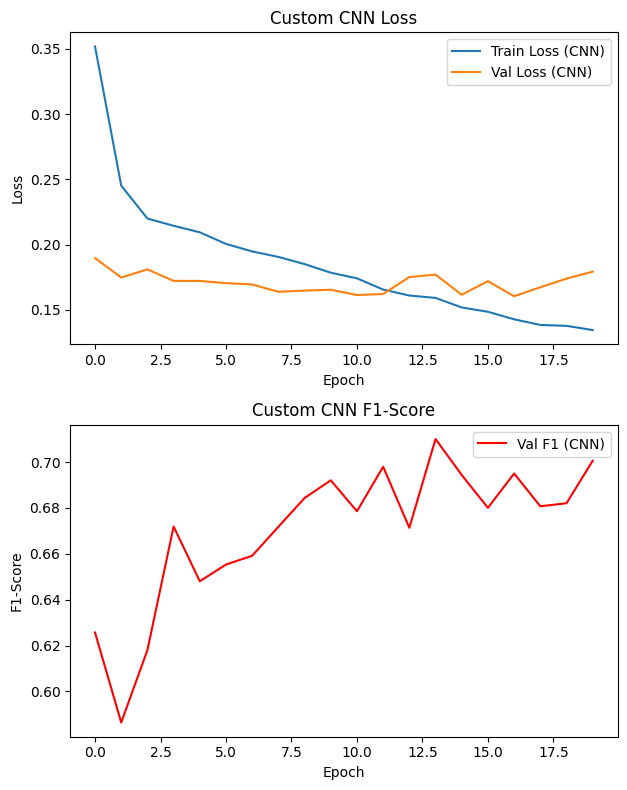

In [ ]:
plt.figure(figsize=(12, 8))

# Loss curves
plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['loss'], label='Train Loss (CNN)')
plt.plot(history_cnn.history['val_loss'], label='Val Loss (CNN)')
plt.title('Custom CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


# F1-score curves
plt.subplot(2, 2, 3)
plt.plot(metrics_cnn.f1_scores, label='Val F1 (CNN)', color='red')
plt.title('Custom CNN F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()


plt.tight_layout()
plt.show()

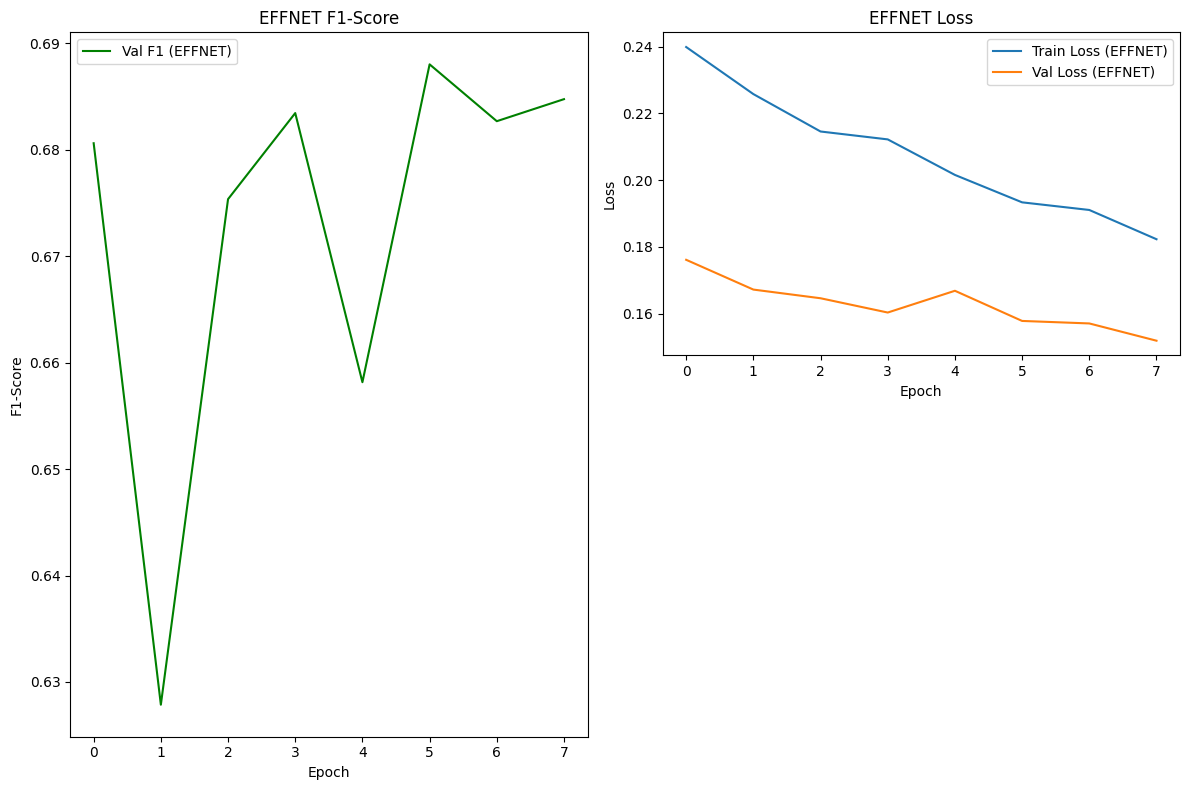

In [ ]:
plt.figure(figsize=(12, 8))

#EFFNET Loss Curves
plt.subplot(2, 2, 2)
plt.plot(history_effnet.history['loss'], label='Train Loss (EFFNET)')
plt.plot(history_effnet.history['val_loss'], label='Val Loss (EFFNET)')
plt.title('EFFNET Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#EFFNET F1-score curves

plt.subplot(1, 2, 1)
plt.plot(metrics_effnet.f1_scores, label='Val F1 (EFFNET)', color='green')
plt.title('EFFNET F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.tight_layout()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step
Custom CNN Metrics:
Hamming Loss: 0.0605
F1-Score: 0.7038
\effnet Metrics:
Hamming Loss: 0.0592
F1-Score: 0.7115

Classification Report (Custom CNN):
              precision    recall  f1-score   support

   classical       0.86      0.95      0.90       621
        jazz       0.00      0.00      0.00        67
     violins       0.00      0.00      0.00        59
        folk       0.00      0.00      0.00        46
    acoustic       0.00      0.00      0.00        35
  electronic       0.78      0.65      0.71       380
         pop       0.56      0.03      0.06       150
        rock       0.83      0.71      0.77       362
       metal       0.00      0.00      0.00        74
       quick       0.00      0.00      0.00         7

   micro avg       0.83      0.61      0.70      1801
   macro avg       0.30      0.23      0.24      1801
weighted avg       0.67      0.61      0.62      1801
 samples avg

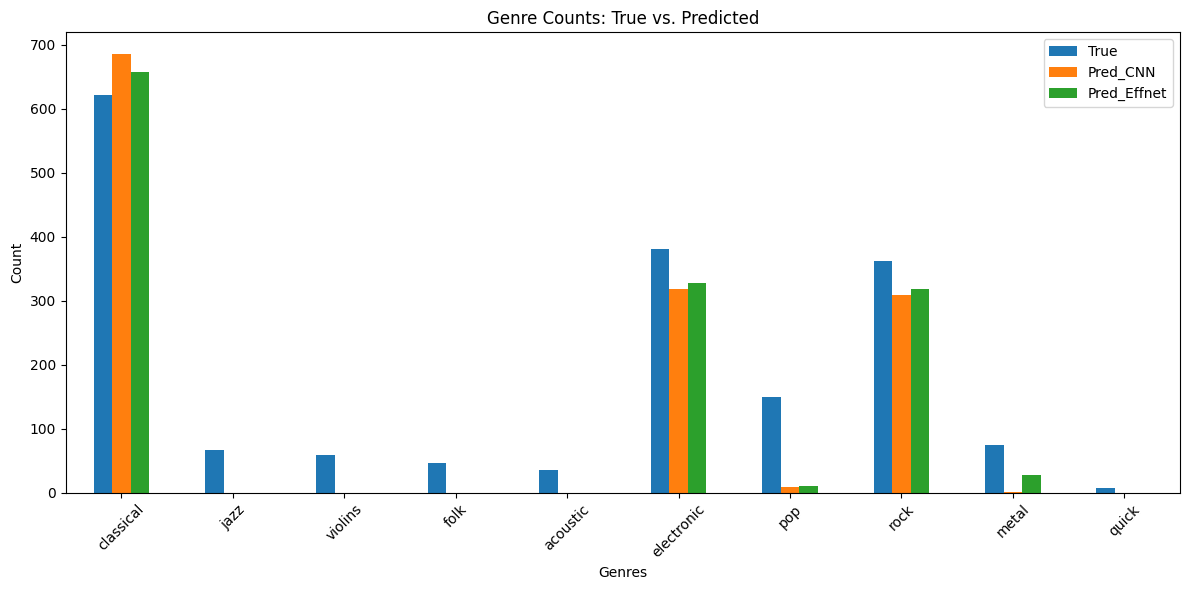

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

#Evaluate models
Y_pred_cnn = (model_cnn.predict(X_test) > 0.5).astype(int)
Y_pred_effnet = (model_effnet.predict(X_test) > 0.5).astype(int)

print("Custom CNN Metrics:")
print(f"Hamming Loss: {hamming_loss(Y_test, Y_pred_cnn):.4f}")
print(f"F1-Score: {f1_score(Y_test, Y_pred_cnn, average='micro'):.4f}")
print("\effnet Metrics:")
print(f"Hamming Loss: {hamming_loss(Y_test, Y_pred_effnet):.4f}")
print(f"F1-Score: {f1_score(Y_test, Y_pred_effnet, average='micro'):.4f}")

# # Classification report
print("\nClassification Report (Custom CNN):")
print(classification_report(Y_test, Y_pred_cnn, target_names=genre_columns))

# Print predictions for 5 test samples
print("\nPredictions vs. Ground Truth (5 samples):")
for i in range(5):
    true_genres = [genre_columns[j] for j in range(len(Y_test[i])) if Y_test[i][j] == 1]
    pred_genres_cnn = [genre_columns[j] for j in range(len(Y_pred_cnn[i])) if Y_pred_cnn[i][j] == 1]
    pred_genres_effnet = [genre_columns[j] for j in range(len(Y_pred_effnet[i])) if Y_pred_effnet[i][j] == 1]
    print(f"Sample {i+1}:")
    print(f"True: {true_genres}")
    print(f"Predicted (CNN): {pred_genres_cnn}")
    print(f"Predicted (VGG16): {pred_genres_effnet}")

# Visualize genre predictions
genre_counts = pd.DataFrame({
    'True': Y_test.sum(axis=0),
    'Pred_CNN': Y_pred_cnn.sum(axis=0),
    'Pred_Effnet': Y_pred_effnet.sum(axis=0)
}, index=genre_columns)

genre_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Genre Counts: True vs. Predicted')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()